In [32]:
# !pip install ipympl

In [33]:
%matplotlib widget

# imports

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from dataclasses import dataclass, field
import random
from mpl_toolkits.mplot3d import Axes3D

# implementations

L is transformation of argument of interpolated function

Simply scale $[0; 1]^2$ into lesser square. Let's denote it with $L'_{ij}$.

In [35]:
@dataclass
class L_prime:
    i: int
    j: int
    n: int
    
    def get(self, t1, t2):
        global n
        
        t1_new = t1 / self.n + (self.i - 1) / self.n
        t2_new = t2 / self.n + (self.j - 1) / self.n
        
        return t1_new, t2_new

This is how argument transformation was defined on lectures presentations. Let's denote it with $L_{ij}$.

In [36]:
@dataclass
class L:
    i: int
    j: int
    n: int
    
    def get(self, t1, t2):
        global n
        
        t1_new = (-1 if (self.i + 1) % 2 == 1 else 1) / self.n * t1 + (self.i - self.i % 2) / self.n
        t2_new = (-1 if (self.j + 1) % 2 == 1 else 1) / self.n * t2 + (self.j - self.j % 2) / self.n
        
        return t1_new, t2_new

Transformation for values.

In [37]:
@dataclass
class F:
    a: float
    b: float
    c: float
    d: float
    f: float

    def get(self, t1, t2, x):
        return self.d * x + self.a * t1 + self.b * t2 + self.c * t1 * t2 + self.f

Class to store both transformations

In [38]:
@dataclass
class W:
    L: L
    F: F

# difference between defined argument transformations

Now to visualise the difference between two argument transformations

In [39]:
n = 10
unit_interval = np.linspace(0, 1, n + 1)

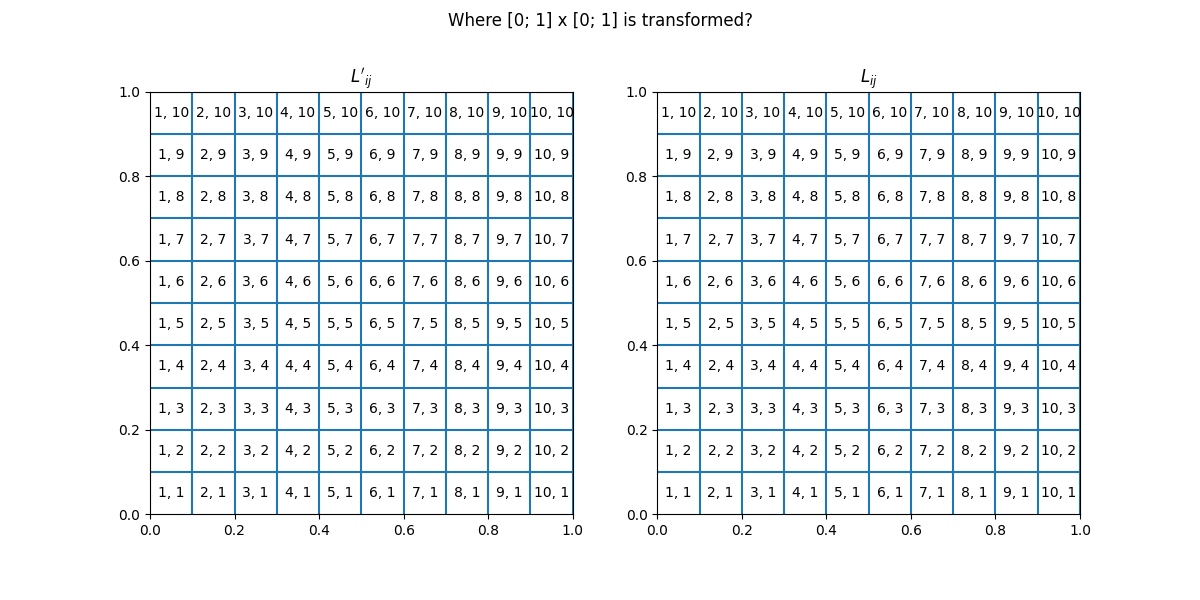

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for i in range(1, n + 1):
    for j in range(1, n + 1):
        l = L_prime(i, j, n)
        ax[0].text(*l.get(0.5, 0.5), f'{i}, {j}', horizontalalignment='center', verticalalignment='center')
    ax[0].axhline(y=i/n)
    ax[0].axvline(x=i/n)
ax[0].set_aspect('equal')
ax[0].set_title('$L\'_{ij}$')

for i in range(1, n + 1):
    for j in range(1, n + 1):
        l = L(i, j, n)
        ax[1].text(*l.get(0.5, 0.5), f'{i}, {j}', horizontalalignment='center', verticalalignment='center')
    ax[1].axhline(y=i/n)
    ax[1].axvline(x=i/n)
ax[1].set_aspect('equal')
ax[1].set_title('$L_{ij}$')

fig.suptitle('Where [0; 1] x [0; 1] is transformed?')

plt.show()

So both $L'_{ij}$ and $L_{ij}$ transform $[0; 1]^2$ into $[\frac{i - 1}{n}; \frac{i}{n}] \times [\frac{j - 1}{n}; \frac{j}{n}]$.

But are images of $L'_{ij}$ and $L_{ij}$ actually identical? Let's check.

Function to generate image based on coordinates.

In [21]:
def gradient_image(X, Y):
    '''
    - X is matrix of x values repeated across y axis
    - Y is matrix of y values repeated across x axis
    '''

    # standarise X
    X = X - X.min()
    X = X / X.max()
    # standarise Y
    Y = Y - Y.min()
    Y = Y / Y.max()

    # based on X and Y return matrix containing lengths to that points
    return np.sqrt(X ** 2 + Y ** 2)

Let's see images of transformations $L'_{ij}([0; 1]^2)$.

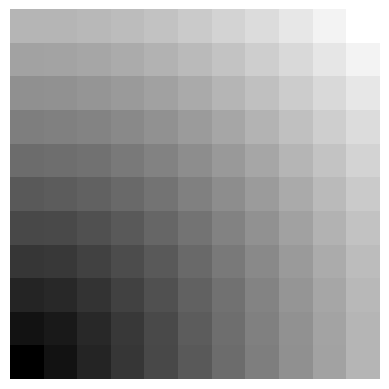

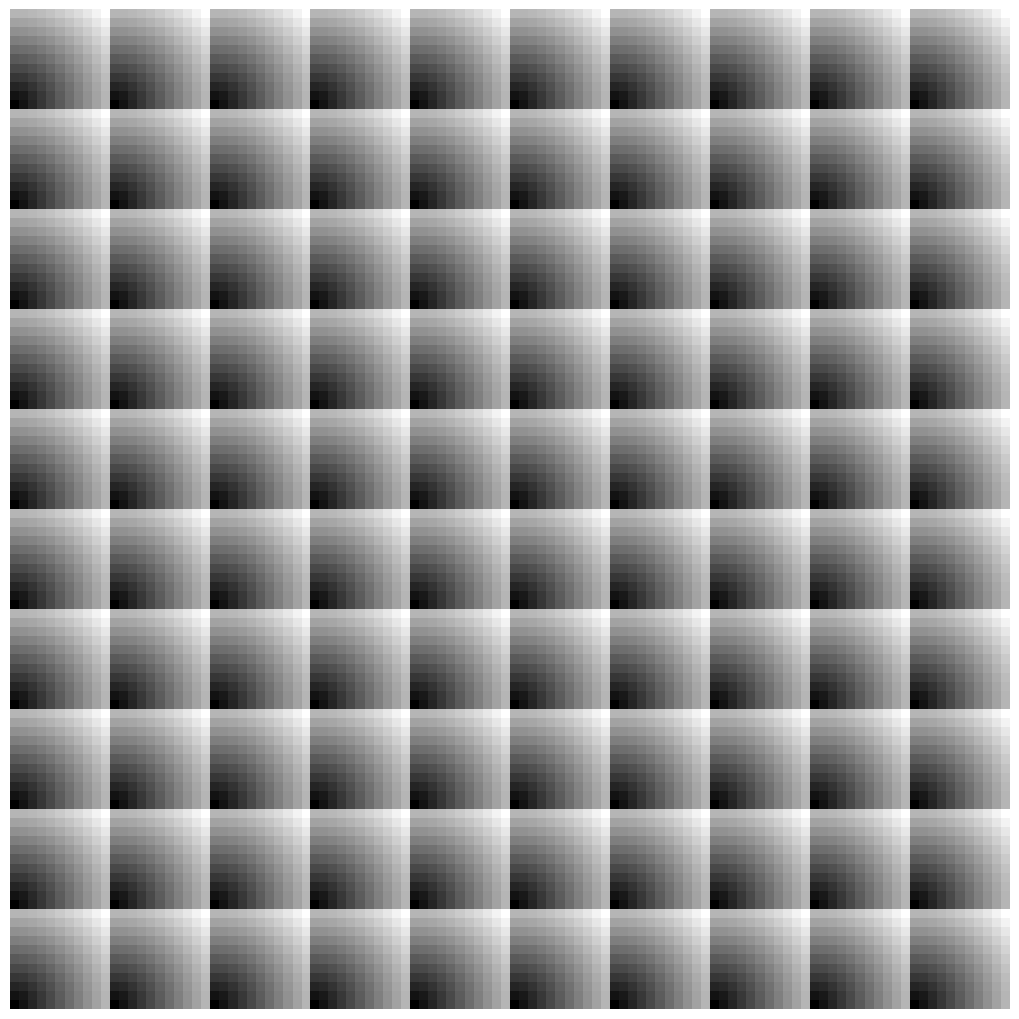

In [23]:
# show reference image
X, Y = np.meshgrid(unit_interval, unit_interval)
plt.imshow(gradient_image(X, Y), cmap='gray', origin='lower')
plt.axis('off')
plt.show()

# create n^2 subplots for all n^2 transformations
fig, ax = plt.subplots(nrows=n, ncols=n, figsize=(10, 10))

for i in range(1, n + 1):
    for j in range(1, n + 1):
        # initialise transformation
        l = L_prime(i, j, n)
        # create image based on transformed square
        ax[i - 1][j - 1].imshow(gradient_image(*l.get(*np.meshgrid(unit_interval, unit_interval))), cmap='gray', origin='lower')
        # hide axis
        ax[i - 1][j - 1].axis('off')
# remove spacings
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
# show
plt.show()
plt.close()

Let's see images of transformations $L_{ij}([0; 1]^2)$.

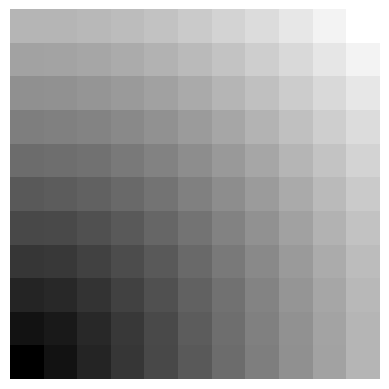

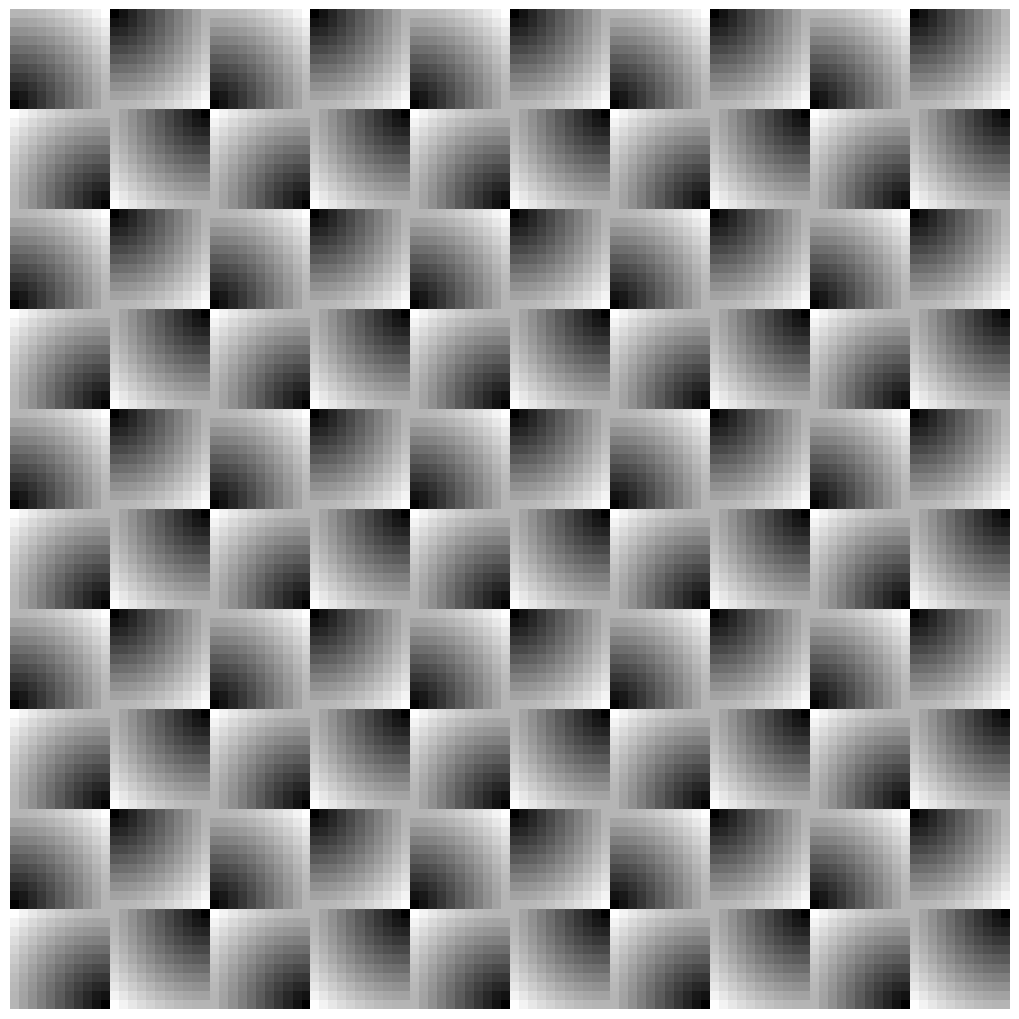

In [25]:
# show reference image
X, Y = np.meshgrid(unit_interval, unit_interval)
plt.imshow(gradient_image(X, Y), cmap='gray', origin='lower')
plt.axis('off')
plt.show()

# create n^2 subplots for all n^2 transformations
fig, ax = plt.subplots(nrows=n, ncols=n, figsize=(10, 10))

for i in range(1, n + 1):
    for j in range(1, n + 1):
        # initialise transformation
        l = L(i, j, n)
        # create image based on transformed square
        ax[i - 1][j - 1].imshow(gradient_image(*l.get(*np.meshgrid(unit_interval, unit_interval))), cmap='gray', origin='lower')
        # hide axis
        ax[i - 1][j - 1].axis('off')
# remove spacings
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
# show
plt.show()
plt.close()

Welp, they are indeed different.

# IFS

calculate coefficients for F

In [7]:
def coefficients(d, x_00, x_0n, x_n0, x_nn, x_l_00, x_l_01, x_l_10, x_l_11):
    f = x_l_00 - d * x_00
    a = x_l_10 - d * x_n0 - f
    b = x_l_01 - d * x_0n - f
    c = x_l_11 - d * x_nn - f - a - b
    
    return a, b, c, f

IFS function itself

In [12]:
def ifs(initial_points, n, N=20000, d=0.5):
    # retrieve several points
    x_00 = initial_points.loc[(initial_points['i'] == 0) & (initial_points['j'] == 0), 'y'].item()
    x_0n = initial_points.loc[(initial_points['i'] == 0) & (initial_points['j'] == n), 'y'].item()
    x_n0 = initial_points.loc[(initial_points['i'] == n) & (initial_points['j'] == 0), 'y'].item()
    x_nn = initial_points.loc[(initial_points['i'] == n) & (initial_points['j'] == n), 'y'].item()

    # initialise matrix of transformations
    transformations = [[None for j in range(n + 1)] for i in range(n + 1)]
    for i in range(1, n + 1):
        for j in range(1, n + 1):
            # retrieve transformation specific points
            x_l_00 = initial_points.loc[(initial_points['i'] == i - i % 2) & (initial_points['j'] == j - j % 2), 'y'].item()
            x_l_01 = initial_points.loc[(initial_points['i'] == (-1 if (i + 1) % 2 == 1 else 1) + i - i % 2) & (initial_points['j'] == j - j % 2), 'y'].item()
            x_l_10 = initial_points.loc[(initial_points['i'] == i - i % 2) & (initial_points['j'] == (-1 if (j + 1) % 2 == 1 else 1) + j - j % 2), 'y'].item()
            x_l_11 = initial_points.loc[(initial_points['i'] == (-1 if (i + 1) % 2 == 1 else 1) + i - i % 2) & (initial_points['j'] == (-1 if (j + 1) % 2 == 1 else 1) + j - j % 2), 'y'].item()

            # calculate coefficients
            a, b, c, f = coefficients(d, x_00, x_0n, x_n0, x_nn, x_l_00, x_l_01, x_l_10, x_l_11)

            # instantiate W object by passing arguments
            transformations[i][j] = W(L(i, j, n), F(a, b, c, d, f))

    # result list of IFS-generated poitns, first one is the first one from initial_points DataFrame
    result = [initial_points.loc[0, ['x1', 'x2', 'y']].tolist()]

    # while we do not have desired number of points
    while len(result) < N:
        # randomly acquire indexes for transformation
        i = random.randint(1,n)
        j = random.randint(1,n)
        t = transformations[i][j]

        # get new 3d-point from transformation based on the last point available in result list and append it to the end
        result.append((*t.L.get(result[-1][0], result[-1][1]), t.F.get(*result[-1])))
    
    return result

# data generation

In [9]:
df = pd.DataFrame.from_dict({'i': [0, 1, 2, 0, 1, 2, 0, 1, 2], 'j':[0, 0, 0, 1, 1, 1, 2, 2, 2], 'x1': [0, 0.5, 1, 0, 0.5, 1, 0, 0.5, 1], 'x2': [0, 0, 0, 0.5, 0.5, 0.5, 1, 1, 1], 'y': [0, 0, 0, 0, 1, 0, 0, 0, 0]}, orient='columns')

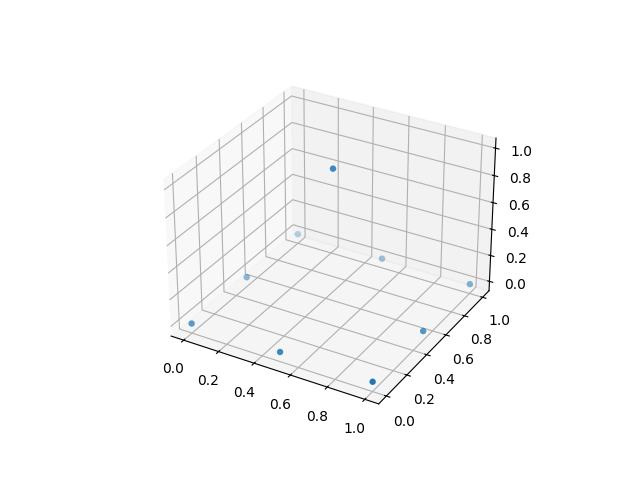

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df['x1'], df['x2'], df['y'], linewidth=0.1)
plt.show()

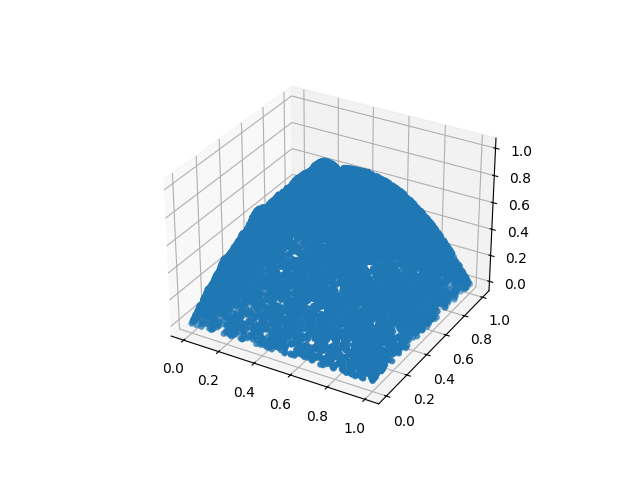

In [13]:
points = pd.DataFrame.from_dict(ifs(df, 2)).rename(columns={0: 'x1', 1: 'x2', 2: 'y'})

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points['x1'], points['x2'], points['y'], linewidth=0.1)
plt.show()

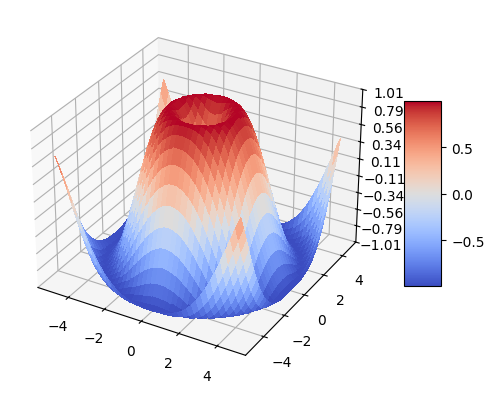

In [30]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [14]:
def generate(func, n):
    unit_interval = np.linspace(0, 1, n + 1)
    
    data = [None for _ in range((n + 1) ** 2)]
    for i in range(n + 1):
        for j in range(n + 1):
            data[i * (n + 1) + j] = (i, j, unit_interval[i], unit_interval[j])
    df = pd.DataFrame.from_dict(data, orient='columns').rename(columns={0: 'i', 1: 'j', 2: 'x1', 3: 'x2'})
    df['y'] = func(df['x1'], df['x2'])

    return df

# some examples

In [23]:
def example(func, n, N=20000, d=0.5, verbose=False, show_plots=False):
    df = generate(func, n)

    if verbose:
        print(df)

    if show_plots:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(df['x1'], df['x2'], df['y'], linewidth=0.1)
        plt.show()

    points = pd.DataFrame.from_dict(ifs(df, n, N, d)).rename(columns={0: 'x1', 1: 'x2', 2: 'y'})

    if show_plots:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(points['x1'], points['x2'], points['y'], linewidth=0.1)
        plt.show()

    return points

how interpolation works based on n

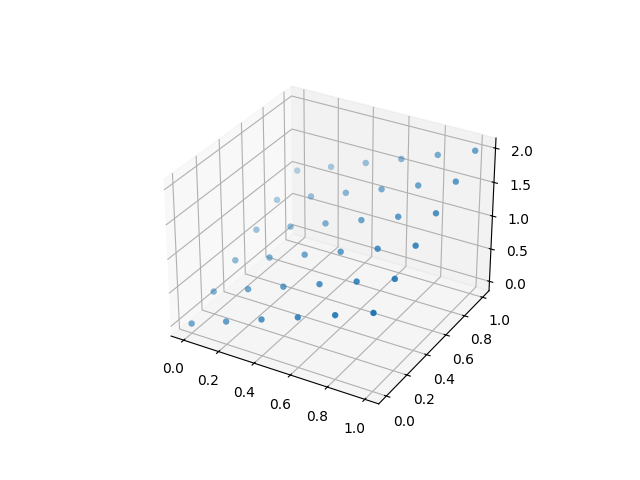

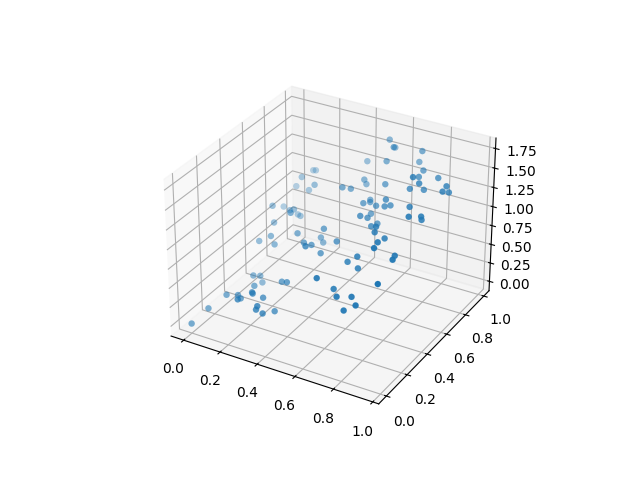

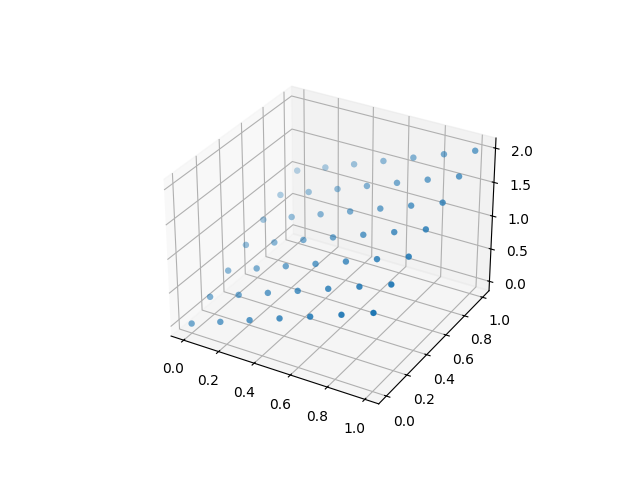

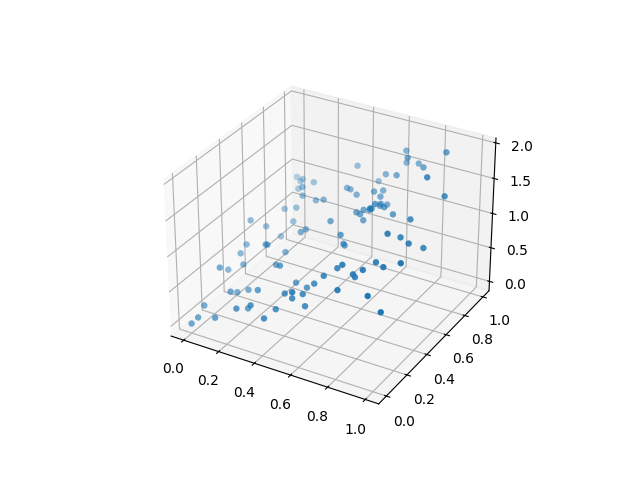

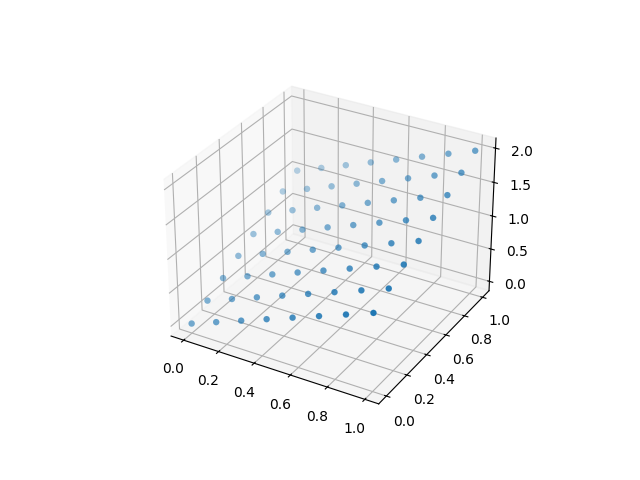

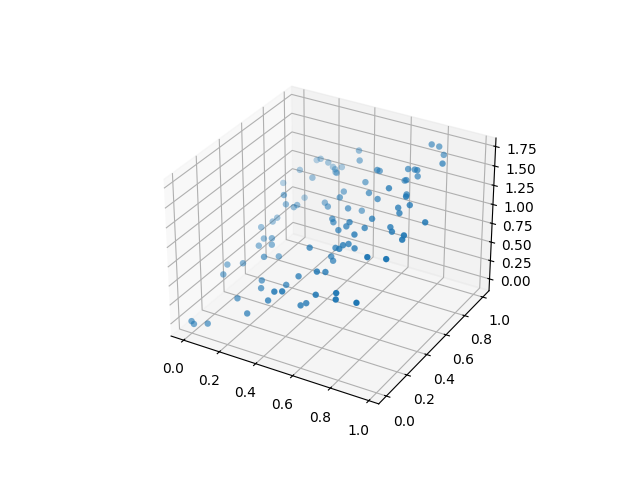

In [24]:
for i in range(5, 8):
    points = example(lambda x1, x2: x1 + x2, i, N=100, show_plots=True)

addition

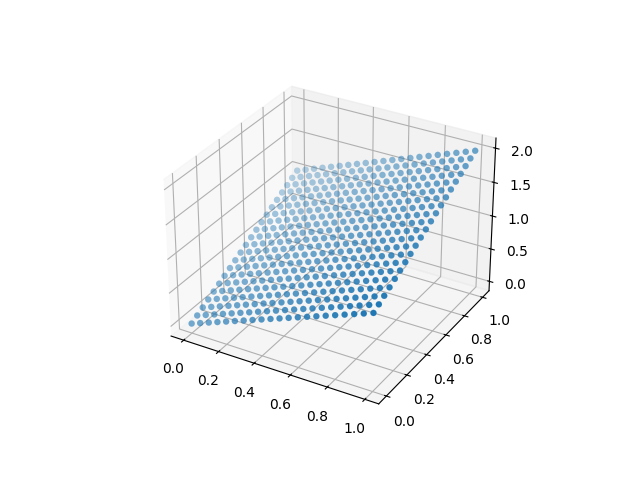

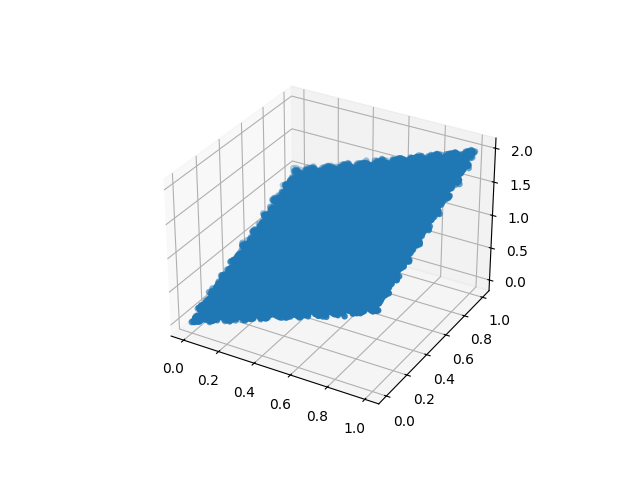

In [25]:
points = example(lambda x1, x2: x1 + x2, 20, show_plots=True)

multiplication

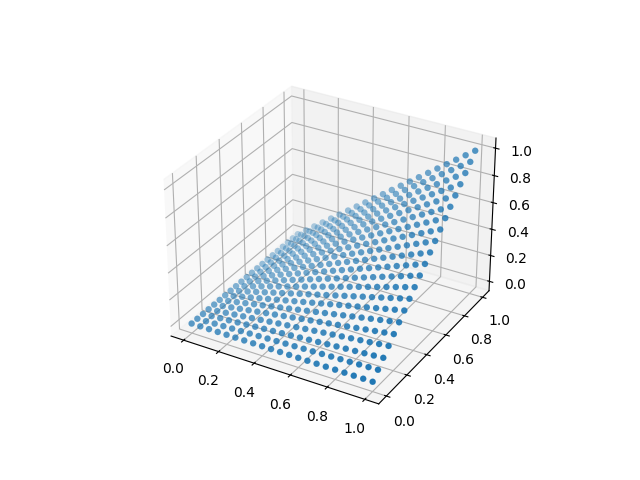

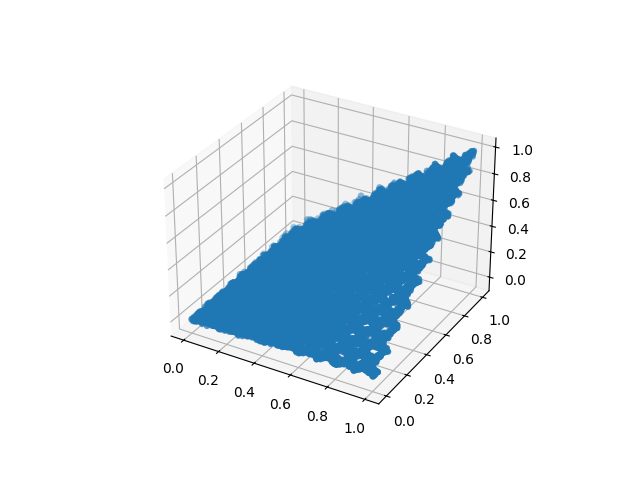

In [27]:
points = example(lambda x1, x2: x1 * x2, 20, show_plots=True)

sum of squares

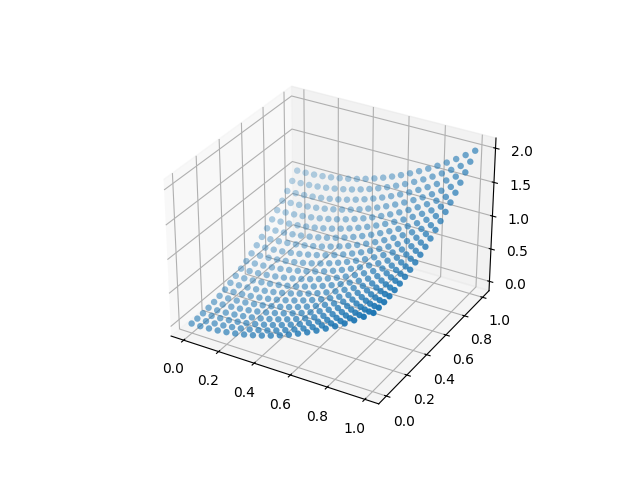

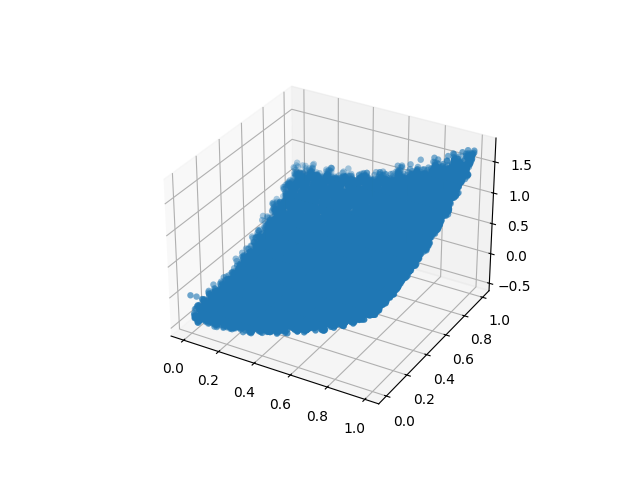

In [29]:
points = example(lambda x1, x2: x1 ** 2 + x2 ** 2, 20, show_plots=True)

sine of sum of squares

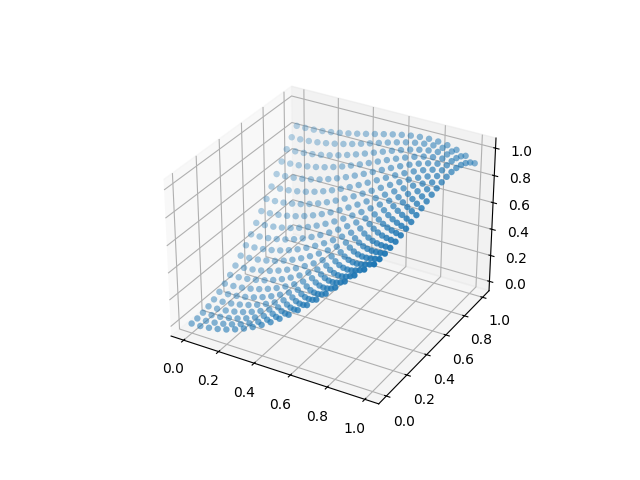

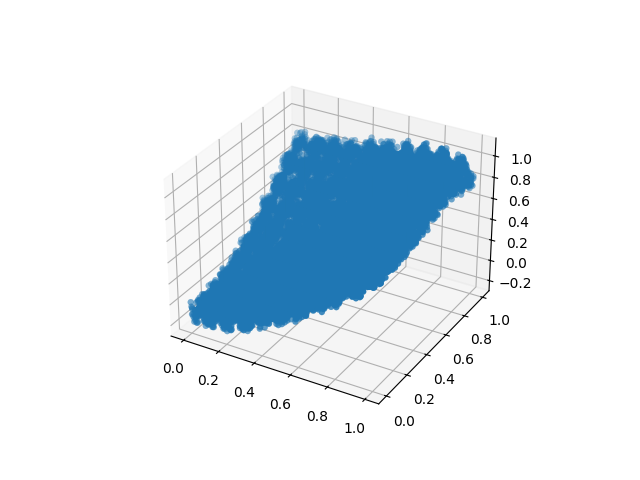

In [30]:
points = example(lambda x1, x2: np.sin(x1 ** 2 + x2 ** 2), 20, show_plots=True)